# Classifiez automatiquement des biens de consommation : *Notebook mission 1"

**Etudiez la faisabilité d'un moteur de classification d'articles**

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce. Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.
 

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégo

Objectif : Etudier la faisabilité d'un moteur de classification des articles en différentes catégories, à partir du texte (en anglais) et de l’image comme dans l’illustration ci-dessous.rie.

In [150]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
import missingno as msno

import sklearn

from sklearn.impute import KNNImputer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from category_encoders import TargetEncoder

# pour le centrage et la réduction
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

import nltk
from nltk.corpus import stopwords

import timeit

# pour cartographie
import folium
import cartopy.crs as ccrs
import geopandas as gpd
import contextily as ctx

from collections import defaultdict

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

print("sklearn version", sklearn.__version__)

print("nltk version", nltk.__version__)

print("folium version", folium.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2
sklearn version 1.2.2
nltk version 3.8.1
folium version 0.19.2


## 1 - Etudier la faisabilité de classification en utilisant des méthodes NLP basiques

### 1.1 - Prétraitement des données textes

Il s'agit de réaliser le pré traitement sur la description des articles.

#### Charger les données textes

In [8]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_6/data_projet/Dataset+projet+prétraitement+textes+images/Flipkart/flipkart_com-ecommerce_sample_1050.csv", \
                   sep=',', low_memory=False)
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [10]:
data.shape

(1050, 15)

Regardons les valeurs manquantes :

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

Tous les articles ont une description et un product_category_tree.

Regardons les doublons :

In [19]:
data.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

Il n'y a pas de doublon.

#### Exploration des descriptions : tokenisation et analyse des fréquences

In [101]:
# tokenizer pour conserver uniquement les caractères alphanumériques
tokenizer = nltk.RegexpTokenizer(r'\w+')
tokenizer.tokenize(data.iloc[1]['description'])

['Specifications',
 'of',
 'Sathiyas',
 'Cotton',
 'Bath',
 'Towel',
 '3',
 'Bath',
 'Towel',
 'Red',
 'Yellow',
 'Blue',
 'Bath',
 'Towel',
 'Features',
 'Machine',
 'Washable',
 'Yes',
 'Material',
 'Cotton',
 'Design',
 'Self',
 'Design',
 'General',
 'Brand',
 'Sathiyas',
 'Type',
 'Bath',
 'Towel',
 'GSM',
 '500',
 'Model',
 'Name',
 'Sathiyas',
 'cotton',
 'bath',
 'towel',
 'Ideal',
 'For',
 'Men',
 'Women',
 'Boys',
 'Girls',
 'Model',
 'ID',
 'asvtwl322',
 'Color',
 'Red',
 'Yellow',
 'Blue',
 'Size',
 'Mediam',
 'Dimensions',
 'Length',
 '30',
 'inch',
 'Width',
 '60',
 'inch',
 'In',
 'the',
 'Box',
 'Number',
 'of',
 'Contents',
 'in',
 'Sales',
 'Package',
 '3',
 'Sales',
 'Package',
 '3',
 'Bath',
 'Towel']

In [113]:
def freq_stats_from_dataframe(df):
    """
    Calcule les fréquences des mots à partir d'un DataFrame contenant les articles et descriptions.
    
    Args:
    - df (pd.DataFrame): DataFrame avec deux colonnes ['product_name', 'description'].
    
    Returns:
    - freq (dict): Fréquences des mots pour chaque article.
    - stats (pd.DataFrame): DataFrame des statistiques par article.
    """
    corpora = defaultdict(list)
    
    # Construction du corpus par image
    for _, row in df.iterrows():
        product = row['product_name']
        description = row['description']
        
        # Tokenisation de la description
        tokens = tokenizer.tokenize(description.lower())
        corpora[product] += tokens
    
    # Calcul des fréquences et des statistiques
    freq = {product: nltk.FreqDist(words) for product, words in corpora.items()}
    stats = {product: {'total': len(words), 'unique': len(nltk.FreqDist(words).keys())} for product, words in corpora.items()}
    
    # Conversion des statistiques en DataFrame
    stats_df = pd.DataFrame.from_dict(stats, orient='index')
    
    return freq, stats_df, corpora

In [115]:
# Application de la fonction
freq, stats_df, corpora = freq_stats_from_dataframe(data)

# Affichage des résultats (total = nombre de mots)
print(stats_df)

                                                    total  unique
Elegance Polyester Multicolor Abstract Eyelet D...    236     132
Sathiyas Cotton Bath Towel                             74      48
Eurospa Cotton Terry Face Towel Set                   216     124
SANTOSH ROYAL FASHION Cotton Printed King sized...    143      73
Jaipur Print Cotton Floral King sized Double Be...    213     111
...                                                   ...     ...
Oren Empower Extra Large Self Adhesive Sticker        429     145
Wallmantra Large Vinyl Sticker Sticker                290     101
Uberlyfe Extra Large Pigmented Polyvinyl Films ...     37      29
Wallmantra Medium Vinyl Sticker Sticker                31      25
Uberlyfe Large Vinyl Sticker                           29      25

[1050 rows x 2 columns]


Regardons le résultat pour un article particulier :

In [99]:
# Exemple d'accès aux fréquences des mots pour une image spécifique
print(freq["Sathiyas Cotton Bath Towel"].most_common())

[('bath', 6), ('towel', 6), ('sathiyas', 3), ('cotton', 3), ('3', 3), ('of', 2), ('red', 2), ('yellow', 2), ('blue', 2), ('design', 2), ('model', 2), ('inch', 2), ('in', 2), ('sales', 2), ('package', 2), ('specifications', 1), ('features', 1), ('machine', 1), ('washable', 1), ('yes', 1), ('material', 1), ('self', 1), ('general', 1), ('brand', 1), ('type', 1), ('gsm', 1), ('500', 1), ('name', 1), ('ideal', 1), ('for', 1), ('men', 1), ('women', 1), ('boys', 1), ('girls', 1), ('id', 1), ('asvtwl322', 1), ('color', 1), ('size', 1), ('mediam', 1), ('dimensions', 1), ('length', 1), ('30', 1), ('width', 1), ('60', 1), ('the', 1), ('box', 1), ('number', 1), ('contents', 1)]


Quelles sont les images des articles avec les descriptions qui ont le plus de mots?

<Axes: title={'center': 'Top 20 des articles par nombre total de mots'}>

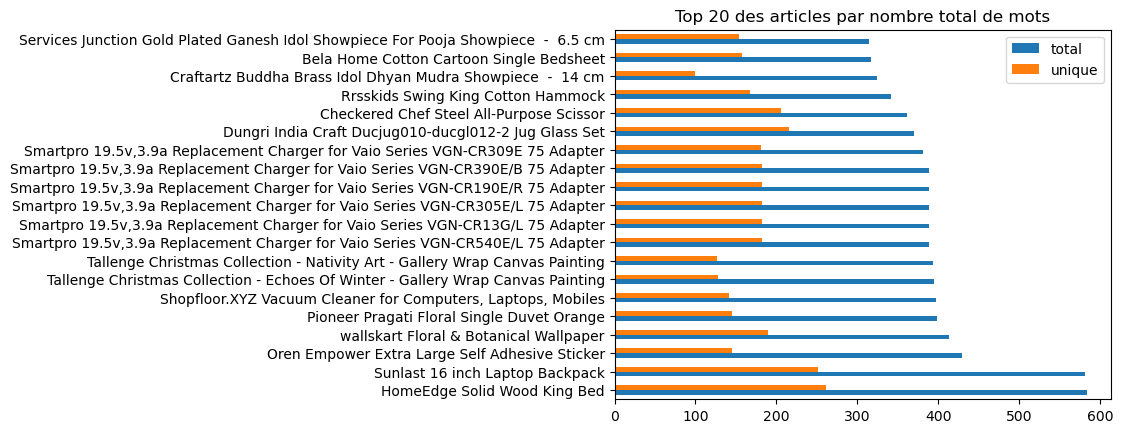

In [109]:
stats_df.sort_values(by='total', ascending=False).head(20).plot(
    kind='barh',
    title='Top 20 des articles par nombre total de mots'
)

Quelles sont les images des articles qui ont le champ lexical (vocabulaire) le plus riche?

<Axes: title={'center': 'Top 20 des articles par nombre total de mots'}>

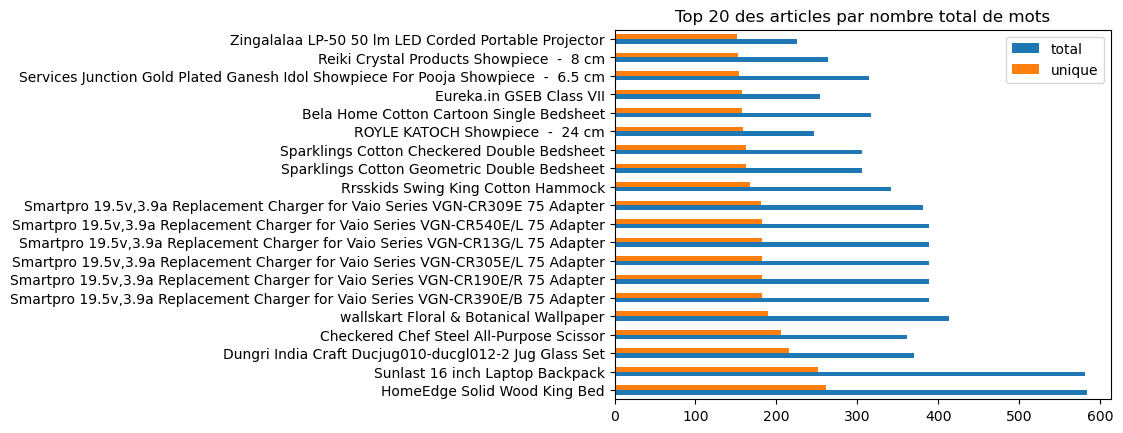

In [107]:
stats_df.sort_values(by='unique', ascending=False).head(20).plot(
    kind='barh',
    title='Top 20 des articles par nombre total de mots'
)

#### Nettoyez et normalisez les données

**Supprimer les stopwords**

Ce sont les mots très courants dans la langue étudiée ("et", "à", "le"... en français) qui n'apportent pas de valeur informative pour la compréhension du "sens" d'un document et corpus. Il sont très fréquents et ralentissent notre travail : nous souhaitons donc les supprimer.

In [128]:
# On récupère la fréquence totale de chaque mot sur tout le corpus d'artistes
freq_totale = nltk.Counter()
for k, v in corpora.items():
    freq_totale += freq[k]

freq_totale.most_common(50)

[('of', 1751),
 ('for', 1436),
 ('the', 1369),
 ('and', 1332),
 ('to', 1058),
 ('in', 1047),
 ('rs', 911),
 ('only', 890),
 ('with', 843),
 ('on', 835),
 ('at', 714),
 ('a', 677),
 ('your', 656),
 ('is', 638),
 ('products', 631),
 ('free', 618),
 ('buy', 581),
 ('delivery', 567),
 ('genuine', 564),
 ('shipping', 564),
 ('cash', 564),
 ('replacement', 559),
 ('1', 554),
 ('cm', 543),
 ('day', 540),
 ('30', 498),
 ('flipkart', 481),
 ('com', 473),
 ('guarantee', 471),
 ('this', 444),
 ('it', 438),
 ('online', 396),
 ('features', 395),
 ('from', 382),
 ('specifications', 371),
 ('s', 365),
 ('you', 360),
 ('price', 352),
 ('watch', 330),
 ('color', 328),
 ('mug', 327),
 ('baby', 320),
 ('pack', 317),
 ('material', 312),
 ('set', 310),
 ('type', 304),
 ('cotton', 299),
 ('box', 292),
 ('general', 288),
 ('5', 286)]

On observe que dans les mots les plus fréquents, il peut y avoir des mots utiles dans une classification des articles. Par exemple, "baby", "mug".

In [130]:
freq_totale.most_common(30)

[('of', 1751),
 ('for', 1436),
 ('the', 1369),
 ('and', 1332),
 ('to', 1058),
 ('in', 1047),
 ('rs', 911),
 ('only', 890),
 ('with', 843),
 ('on', 835),
 ('at', 714),
 ('a', 677),
 ('your', 656),
 ('is', 638),
 ('products', 631),
 ('free', 618),
 ('buy', 581),
 ('delivery', 567),
 ('genuine', 564),
 ('shipping', 564),
 ('cash', 564),
 ('replacement', 559),
 ('1', 554),
 ('cm', 543),
 ('day', 540),
 ('30', 498),
 ('flipkart', 481),
 ('com', 473),
 ('guarantee', 471),
 ('this', 444)]

On peut cependant supprimer sans risque les 30 premiers mots les plus fréquents.

In [152]:
# On décide manière un peu arbitraire du nombre de mots les plus fréquents à supprimer. On pourrait afficher un graphe d'évolution du nombre de mots pour se rendre compte et avoir une meilleure heuristique. 
most_freq = list(zip(*freq_totale.most_common(30)))[0]

# On créé notre set de stopwords final qui cumule ainsi les 100 mots les plus fréquents du corpus ainsi que l'ensemble de stopwords par défaut présent dans la librairie NLTK
sw = set()
sw.update(most_freq)
sw.update(tuple(nltk.corpus.stopwords.words('english')))

In [154]:
def freq_stats_from_dataframe_without_stopwords(df, sw):
    """
    Calcule les fréquences des mots à partir d'un DataFrame contenant les articles et descriptions, sans les stopwords.
    
    Args:
    - df (pd.DataFrame): DataFrame avec deux colonnes ['product_name', 'description'].
    
    Returns:
    - freq (dict): Fréquences des mots pour chaque article.
    - stats (pd.DataFrame): DataFrame des statistiques par article.
    """
    corpora = defaultdict(list)
    
    # Construction du corpus par image
    for _, row in df.iterrows():
        product = row['product_name']
        description = row['description']
        
        # Tokenisation de la description
        tokens = tokenizer.tokenize(description.lower())
        corpora[product] += [w for w in tokens if not w in sw]
    
    # Calcul des fréquences et des statistiques
    freq = {product: nltk.FreqDist(words) for product, words in corpora.items()}
    stats = {product: {'total': len(words), 'unique': len(nltk.FreqDist(words).keys())} for product, words in corpora.items()}
    
    # Conversion des statistiques en DataFrame
    stats_df = pd.DataFrame.from_dict(stats, orient='index')
    
    return freq, stats_df, corpora

In [156]:
# Application de la fonction
freq, stats_df, corpora = freq_stats_from_dataframe_without_stopwords(data, sw)

# Affichage des résultats (total = nombre de mots)
print(stats_df)

                                                    total  unique
Elegance Polyester Multicolor Abstract Eyelet D...    158     107
Sathiyas Cotton Bath Towel                             67      43
Eurospa Cotton Terry Face Towel Set                   167      98
SANTOSH ROYAL FASHION Cotton Printed King sized...    122      64
Jaipur Print Cotton Floral King sized Double Be...    165      90
...                                                   ...     ...
Oren Empower Extra Large Self Adhesive Sticker        239     101
Wallmantra Large Vinyl Sticker Sticker                154      66
Uberlyfe Extra Large Pigmented Polyvinyl Films ...     20      12
Wallmantra Medium Vinyl Sticker Sticker                14       8
Uberlyfe Large Vinyl Sticker                           12       8

[1050 rows x 2 columns]
